In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import cv2
from tqdm.notebook import tqdm

from fastai.vision.all import *
from fastai.vision import models
import torch

import sys
sys.path.append('../')
from src.types.tensor_tiles import BrightfieldTile, FluorescenceTile
from src.stats_reader import DataStats
from src.transforms.augmentations import PairAugmentations
from src.transforms.pair_transform import PairTransform
from src.losses import Chan_MSE, TileMSELoss, VGGTrainedPerceptualLoss, VGGPerceptualLoss
from src.models.unet_models import resnet50_7chan

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
bs = 4
zoom = 60
stats_path = '../configs/data_statistics.json'
STATS = DataStats(stats_path, zoom)

path = '../input/tile_set/'
df = pd.read_csv(os.path.join(path, f'train_{zoom}.csv'))
df.head()

fn  fold  \
0    input_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__0.npy     0   
1  input_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__192.npy     0   
2  input_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__384.npy     0   
3  input_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__576.npy     0   
4  input_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__768.npy     0   

                                    slide_name  start_x  start_y  tile_sz  \
0  AssayPlate_Greiner_#655090_B03_T0001F001L01        0        0      256   
1  AssayPlate_Greiner_#655090_B03_T0001F001L01        0      192      256   
2  AssayPlate_Greiner_#655090_B03_T0001F001L01        0      384      256   
3  AssayPlate_Greiner_#655090_B03_T0001F001L01        0      576      256   
4  AssayPlate_Greiner_#655090_B03_T0001F001L01        0      768      256   

   slide_width  slide_height  \
0         2556          2156   
1         2556          2156   
2         2556          2156   
3         2556          2156   
4         2556          2156   

                                                               target_fn  
0    target_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__0.npy  
1  target_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__192.npy  
2  target_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__384.npy  
3  target_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__576.npy  
4  target_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__768.npy

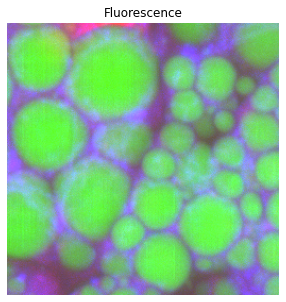

In [4]:
targ = FluorescenceTile.create(os.path.join(path, df.iloc[100].target_fn), STATS)
targ.show();

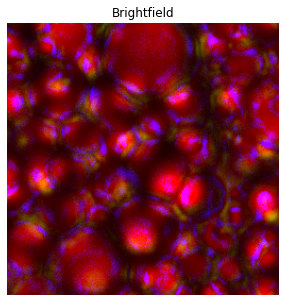

In [5]:
s = BrightfieldTile.create(os.path.join(path, df.iloc[25].fn), STATS)
s.show(stats=STATS);

In [6]:
brightfield_paths = [os.path.join(path, fn) for fn in df.fn.values]
fluorescence_paths = [os.path.join(path, fn) for fn in df.target_fn.values]
is_train = [fold != 0 for fold in df.fold.values]
df['is_val'] = ~np.array(is_train)

augmentations = PairAugmentations()

tfm = PairTransform(
    brightfield_paths, 
    fluorescence_paths, 
    stats=STATS,
    augment_func=augmentations,
    augment_samples=is_train
)

In [7]:
splitter = FuncSplitter(lambda o: df[df.fn == str(o).replace(path,'')].is_val.values[0])
splits = splitter(brightfield_paths)

tls = TfmdLists(range(len(brightfield_paths)), tfm, splits=splits)
dls = tls.dataloaders(bs=bs)
dls = dls.cuda()

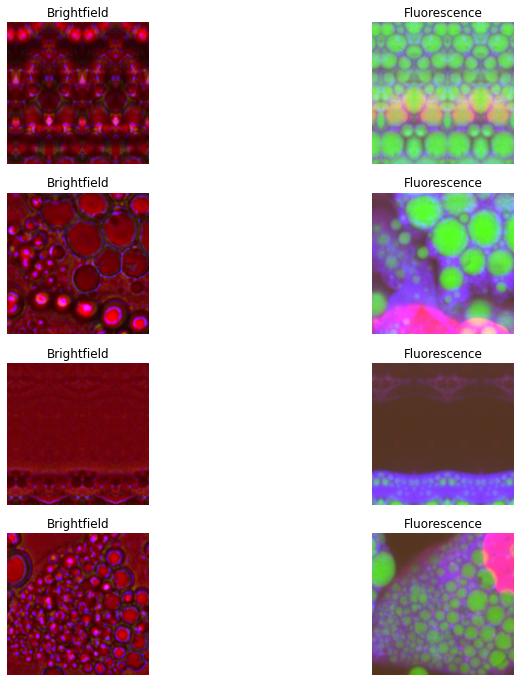

In [8]:
dls.show_batch(stats=STATS)

In [32]:
learn = unet_learner(
    dls, 
    resnet50_7chan, 
    n_out=3, 
    loss_func=TileMSELoss(), 
    metrics=[TileMSELoss(), Chan_MSE(chan=0), Chan_MSE(chan=1), Chan_MSE(chan=2)]
)

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=1.737800812406931e-05)

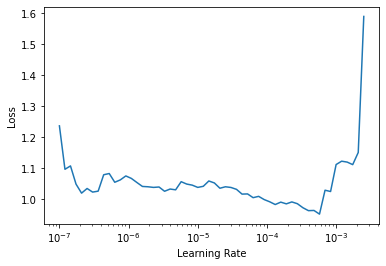

In [15]:
learn.lr_find()

In [33]:
learn.fine_tune(1, base_lr=1e-3)

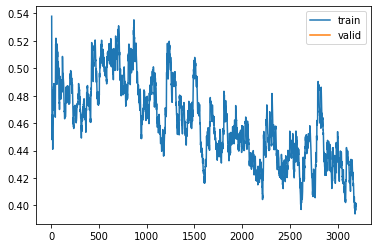

In [34]:
learn.recorder.plot_loss()

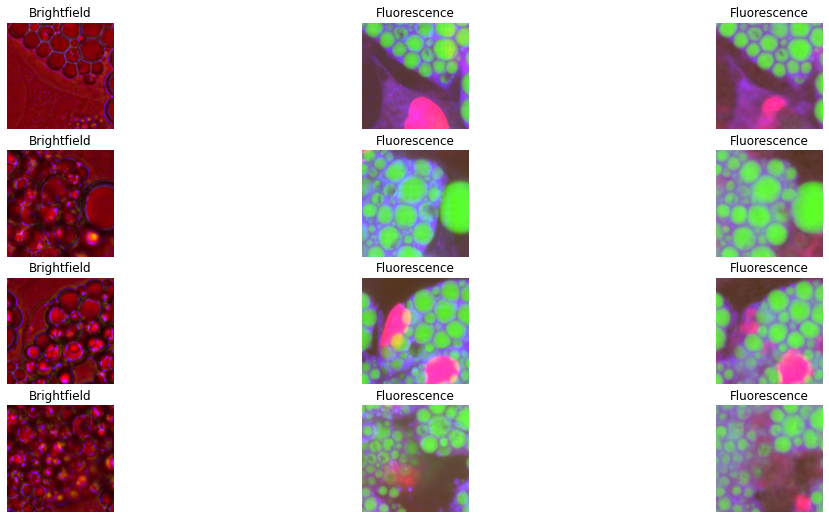

In [35]:
learn.show_results(stats=STATS)

In [36]:
learn.fit_flat_cos(10, lr=1e-4)

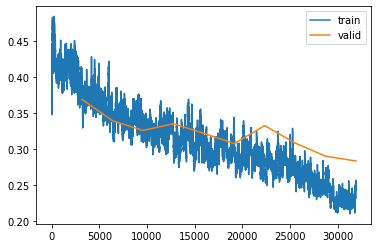

In [37]:
learn.recorder.plot_loss()

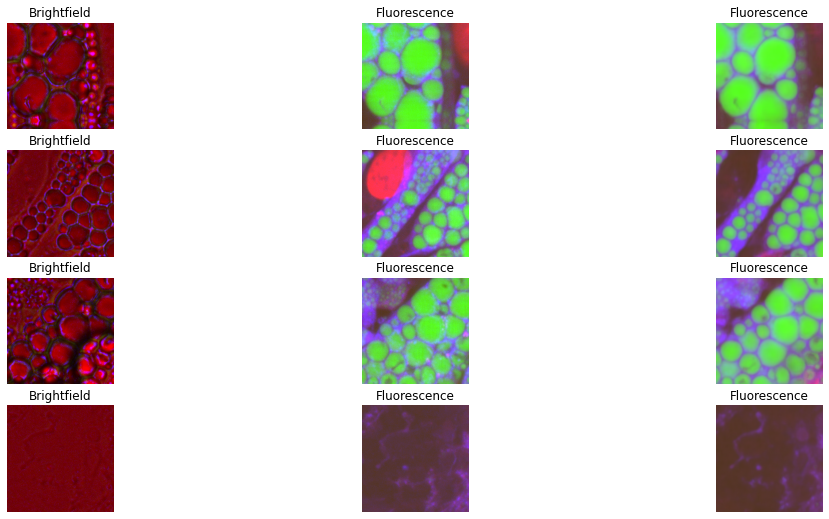

In [39]:
learn.show_results(stats=STATS)

In [50]:
# save only state dict (weights) - requires the model when loading
torch.save(learn.model.state_dict(), '../models/mse_baseline_test.pth')

## Change loss to perceptual

In [33]:
#loss = VGGPerceptualLoss()
loss = VGGTrainedPerceptualLoss(pretrained_path='../models/vgg16_20201105_zoom60_siamese.pth')

In [34]:
learn = unet_learner(
    dls, 
    resnet50_7chan, 
    n_out=3, 
    loss_func=loss, 
    metrics=[TileMSELoss(), Chan_MSE(chan=0), Chan_MSE(chan=1), Chan_MSE(chan=2)]
)

In [35]:
state_dict = torch.load('../models/mse_baseline_test.pth')

In [36]:
learn.model.load_state_dict(state_dict)

<All keys matched successfully>

In [37]:
learn.fit_flat_cos(1, lr=1e-4)

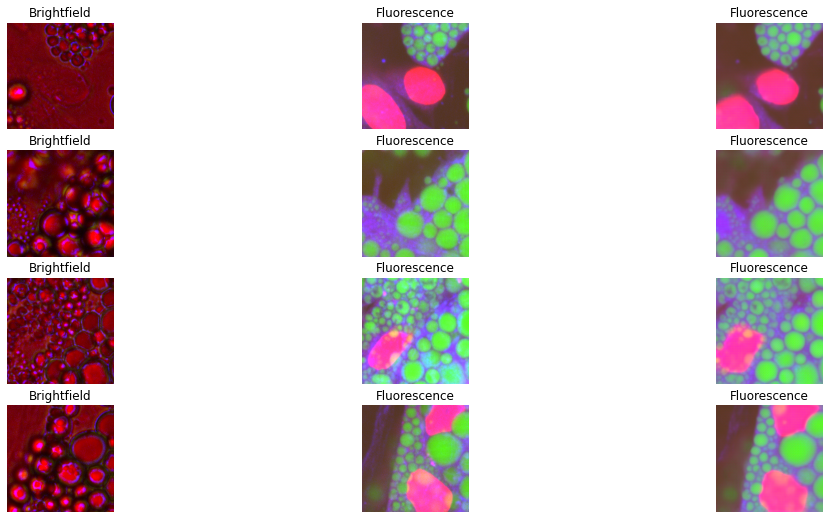

In [38]:
learn.show_results(stats=STATS)

In [79]:
xs, ys = dls.one_batch()

In [49]:
# check output featuremaps
from src.models.loss_model import get_loss_model_vgg
loss_model = get_loss_model_vgg()
loss_model.load_state_dict(torch.load('../models/vgg16_20201105_zoom60_siamese.pth'))
loss_model = loss_model.eval()
loss_model = loss_model.cuda()

In [75]:
block_0 = loss_model.encoder[0][:4]
block_1 = loss_model.encoder[0][:9]
block_2 = loss_model.encoder[0][:16]
block_3 = loss_model.encoder[0][:23]

In [80]:
block_0_out = block_0(ys)
block_1_out = block_1(ys)
block_2_out = block_2(ys)
block_3_out = block_3(ys)
bloc_outputs = [block_0_out, block_1_out, block_2_out, block_3_out]

<AxesSubplot:>

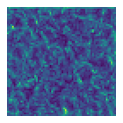

In [81]:
TensorImage(torch.amax(block_3_out[0], dim=0)).show()

In [93]:
preds = learn.model(xs)
pred_block_0_out = block_0(preds)
pred_block_1_out = block_1(preds)
pred_block_2_out = block_2(preds)
pred_block_3_out = block_3(preds)
pred_block_outputs = [pred_block_0_out, pred_block_1_out, pred_block_2_out, pred_block_3_out]

In [100]:
for out_block in pred_block_outputs:
    #print(out_block.shape)
    print(out_block.reshape(-1).shape[0] / bs)

4194304.0
2097152.0
1048576.0
1048576.0


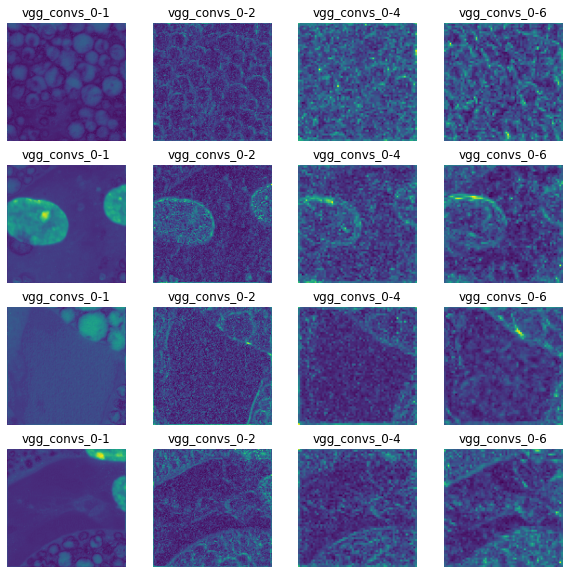

In [92]:
ctxs = get_grid(bs * 4, nrows=None, ncols=4, figsize=(10,10))
titles = ['vgg_convs_0-1', 'vgg_convs_0-2', 'vgg_convs_0-4' ,'vgg_convs_0-6']
for i,ctx in enumerate(ctxs):
    TensorImage(torch.amax(bloc_outputs[i%4][i//4], dim=0)).show(ctx=ctx, title=titles[i%4])

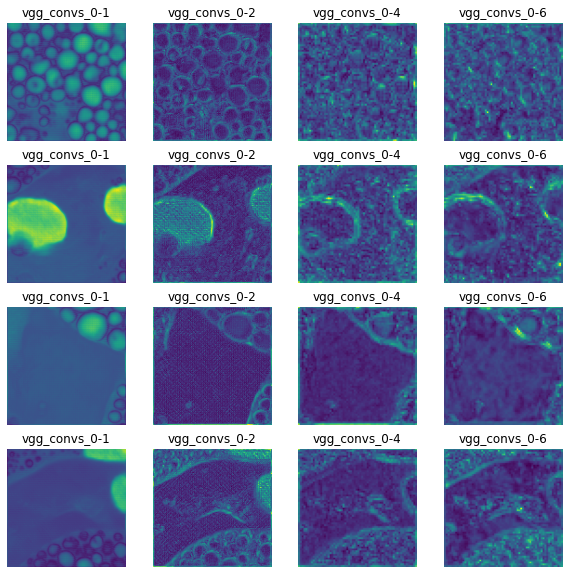

In [94]:
ctxs = get_grid(bs * 4, nrows=None, ncols=4, figsize=(10,10))
titles = ['vgg_convs_0-1', 'vgg_convs_0-2', 'vgg_convs_0-4' ,'vgg_convs_0-6']
for i,ctx in enumerate(ctxs):
    TensorImage(torch.amax(pred_block_outputs[i%4][i//4], dim=0)).show(ctx=ctx, title=titles[i%4])

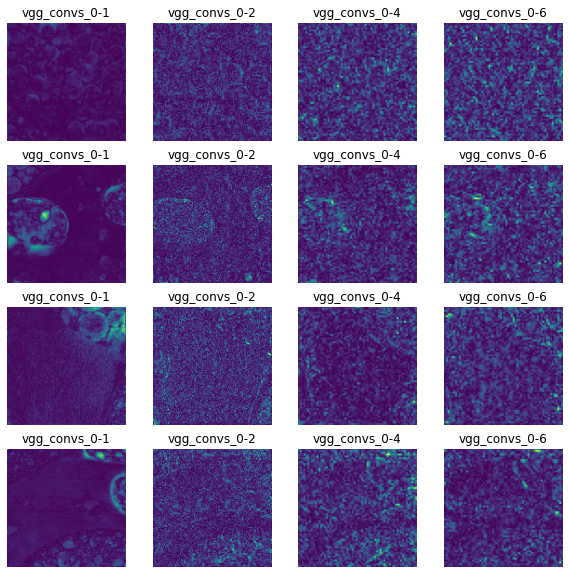

In [117]:
ctxs = get_grid(bs * 4, nrows=None, ncols=4, figsize=(10,10))
titles = ['vgg_convs_0-1', 'vgg_convs_0-2', 'vgg_convs_0-4' ,'vgg_convs_0-6']
for i,ctx in enumerate(ctxs):
    a = tensor(torch.amax(bloc_outputs[i%4][i//4], dim=0)).detach().cpu().numpy()
    b = tensor(torch.amax(pred_block_outputs[i%4][i//4], dim=0)).detach().cpu().numpy()
    TensorImage(tensor(np.abs(a - b))).show(ctx=ctx, title=titles[i%4])

### MAE & MSE outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

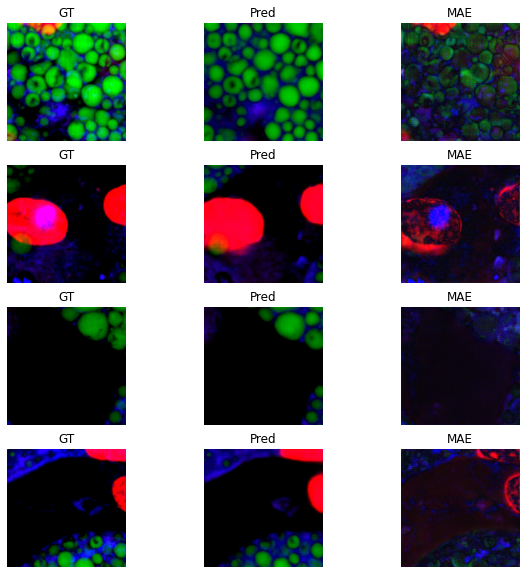

In [127]:
ctxs = get_grid(bs * 4, nrows=None, ncols=3, figsize=(10,10))
titles = ['GT', 'Pred', 'MAE']
brightness_f = 0.4
for i,ctx in enumerate(ctxs):
    if i % 3 == 0: # gt
        TensorImage(ys[i//3] * brightness_f).show(ctx=ctx, title=titles[i%3])
    if i % 3 == 1: # pred
        TensorImage(preds[i//3] * brightness_f).show(ctx=ctx, title=titles[i%3])
    if i % 3 == 2:
        a = tensor(ys[i//3]).detach().cpu().numpy() * brightness_f
        b = tensor(preds[i//3]).detach().cpu().numpy() * brightness_f
        TensorImage(tensor(np.abs(a - b))).show(ctx=ctx, title=titles[i%3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

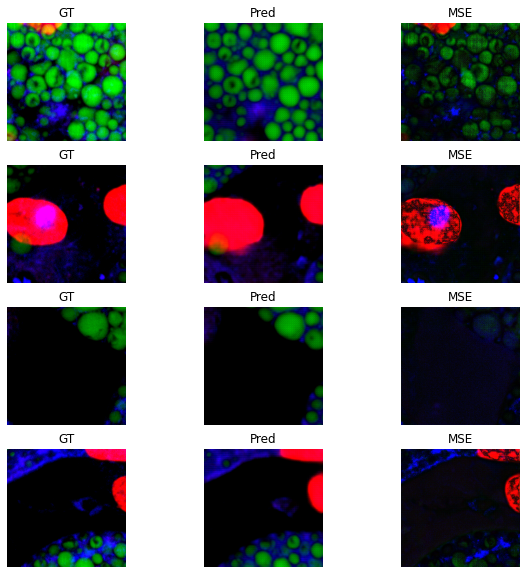

In [126]:
ctxs = get_grid(bs * 4, nrows=None, ncols=3, figsize=(10,10))
titles = ['GT', 'Pred', 'MSE']
brightness_f = 0.4
for i,ctx in enumerate(ctxs):
    if i % 3 == 0: # gt
        TensorImage(ys[i//3] * brightness_f).show(ctx=ctx, title=titles[i%3])
    if i % 3 == 1: # pred
        TensorImage(preds[i//3] * brightness_f).show(ctx=ctx, title=titles[i%3])
    if i % 3 == 2:
        a = tensor(ys[i//3]).detach().cpu().numpy() * brightness_f
        b = tensor(preds[i//3]).detach().cpu().numpy() * brightness_f
        TensorImage(tensor(np.abs(a**2 - b**2))).show(ctx=ctx, title=titles[i%3])

## Compare to imagenet trained perceptual loss

In [128]:
loss = VGGPerceptualLoss()

In [129]:
learn = unet_learner(
    dls, 
    resnet50_7chan, 
    n_out=3, 
    loss_func=loss, 
    metrics=[TileMSELoss(), Chan_MSE(chan=0), Chan_MSE(chan=1), Chan_MSE(chan=2)]
)

In [130]:
state_dict = torch.load('../models/mse_baseline_test.pth')
learn.model.load_state_dict(state_dict)

<All keys matched successfully>

In [131]:
learn.fit_flat_cos(1, lr=1e-4)

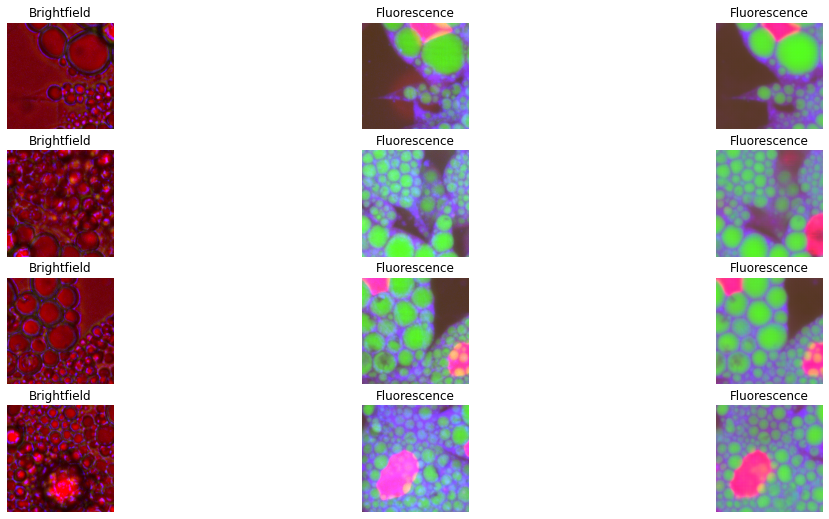

In [132]:
learn.show_results(stats=STATS)

In [136]:
import torchvision
blocks = []
blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
blocks.append(torchvision.models.vgg16(pretrained=True).features[:9].eval())
blocks.append(torchvision.models.vgg16(pretrained=True).features[:16].eval())
blocks.append(torchvision.models.vgg16(pretrained=True).features[:23].eval())

In [140]:
blocks[-1]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [138]:
block_0_out = blocks[0].cuda()(ys)
block_1_out = blocks[1].cuda()(ys)
block_2_out = blocks[2].cuda()(ys)
block_3_out = blocks[3].cuda()(ys)
bloc_outputs = [block_0_out, block_1_out, block_2_out, block_3_out]

In [141]:
for out_block in bloc_outputs:
    print(out_block.shape)
    print(out_block.reshape(-1).shape[0] / bs)

(4, 64, 256, 256)
4194304.0
(4, 128, 128, 128)
2097152.0
(4, 256, 64, 64)
1048576.0
(4, 512, 32, 32)
524288.0


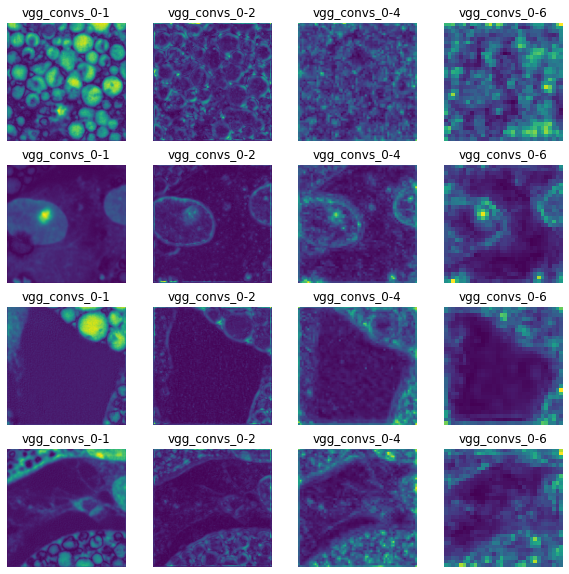

In [139]:
ctxs = get_grid(bs * 4, nrows=None, ncols=4, figsize=(10,10))
titles = ['vgg_convs_0-1', 'vgg_convs_0-2', 'vgg_convs_0-4' ,'vgg_convs_0-6']
for i,ctx in enumerate(ctxs):
    TensorImage(torch.amax(bloc_outputs[i%4][i//4], dim=0)).show(ctx=ctx, title=titles[i%4])

In [133]:
preds = learn.model(xs)
pred_block_0_out = block_0(preds)
pred_block_1_out = block_1(preds)
pred_block_2_out = block_2(preds)
pred_block_3_out = block_3(preds)
pred_block_outputs = [pred_block_0_out, pred_block_1_out, pred_block_2_out, pred_block_3_out]

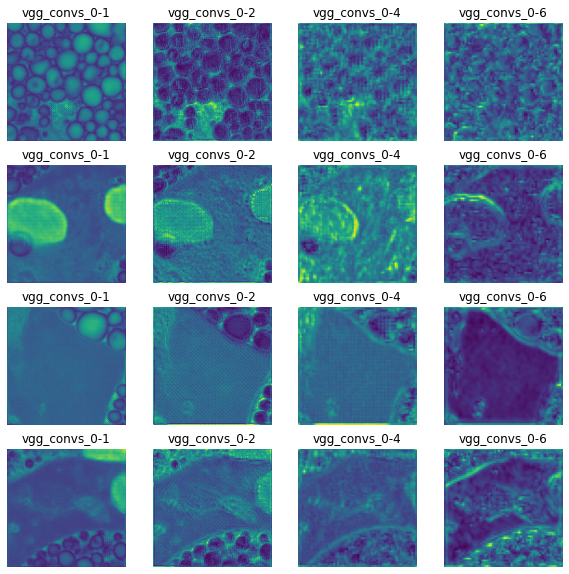

In [134]:
ctxs = get_grid(bs * 4, nrows=None, ncols=4, figsize=(10,10))
titles = ['vgg_convs_0-1', 'vgg_convs_0-2', 'vgg_convs_0-4' ,'vgg_convs_0-6']
for i,ctx in enumerate(ctxs):
    TensorImage(torch.amax(pred_block_outputs[i%4][i//4], dim=0)).show(ctx=ctx, title=titles[i%4])